# Trabajo Practico Integrador parte 1- Análisis de Datos

**Grupo:** Mariano Campos, Leandro Lepera, Ojeda Juan Cruz  
**Cohorte:** 19Co2024 - CEIA  
**Materia:** Análisis de Datos  
**Tema asignado:** Meteorología en Argentina


## 1. Motivación

Para este trabajo final, se nos asignó el dataset relacionado con la **meteorología en Argentina**, con el objetivo de aplicar herramientas de análisis de datos para comprender mejor fenómenos climatológicos recientes y su comparación con patrones históricos.

Contamos con dos fuentes de información:
- Un registro **diario** de temperaturas del **último año**.
- Estadísticas **mensuales promedio** de los **últimos 30 años** (1991–2020).

## 2. Contexto y descripción del dataset

Para este trabajo se utilizan conjuntos de datos oficiales del **Servicio Meteorológico Nacional (SMN)** de Argentina, extraídos de su portal de datos abiertos.

### Dataset 1: Registro diario de temperaturas (último año)

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Registros **diarios** de temperaturas mínimas y máximas correspondientes a múltiples estaciones meteorológicas distribuidas en el país.
- **Variables principales:** Fecha, nombre de la estación, provincia, temperatura mínima, temperatura máxima.
- **Periodo:** Últimos 365 días (a partir de la fecha de descarga).
- **Formato original:** Texto plano delimitado por tabulaciones (`.txt`), una fila por día por estación.

### Dataset 2: Estadísticas normales (promedios 1991–2020)

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Promedios **mensuales** de variables meteorológicas calculados sobre un periodo de 30 años (1991 a 2020), utilizados como referencia climática.
- **Variables principales:** Estación, variable medida (ej. temperatura mínima, temperatura máxima), y valores mensuales de enero a diciembre.
- **Periodo:** Promedios 1991–2020.
- **Formato original:** Texto plano delimitado por tabulaciones (`.txt`), una fila por estación y por variable.

### Dataset 3: Ubicación geográfica de estaciones meteorológicas

- **Fuente:** Datos abiertos del SMN.
- **Contenido:** Información geográfica de las estaciones meteorológicas utilizadas en los otros dos datasets.
- **Variables principales:** Nombre de estación, provincia, latitud, longitud, altitud, código OACI.
- **Uso en este trabajo:** Se utilizó para incorporar coordenadas geográficas a las estaciones, lo que permitió realizar análisis regionales y visualizaciones espaciales.
- **Archivo:** `estaciones_smn.txt`

### Consideraciones

Todos los archivos fueron verificados con los docentes como los correspondientes al tema asignado. Durante el análisis, se realizaron transformaciones para adecuar los formatos (por ejemplo, convertir el segundo dataset a formato largo) y unificar criterios para permitir la comparación entre las fuentes. Además, el uso del tercer dataset permitió agrupar estaciones por región geográfica y enriquecer el análisis climático.


In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json

## 2.1 Exploración y comprensión de los datos

En esta sección se describe la estructura general de los datasets, visualizando las primeras filas, tipos de datos y cantidad de registros. También se realiza una primera evaluación de valores faltantes y posibles inconsistencias.

---

### Dataset: registro_temperatura365d_smn

In [137]:
df_ly_raw = pd.read_fwf("Datos/registro_temperatura365d_smn.txt", skiprows=1, encoding="latin1") #La primera linea esta en blanco (skiprows=1)
print(f"Cantidad de filas: {df_ly_raw.shape[0]}")
print(f"Cantidad de columnas: {df_ly_raw.shape[1]}")

df_ly_raw.head()

Cantidad de filas: 42916
Cantidad de columnas: 4


,FECHA,TMAX,TMIN,NOMBRE
0,--------,-----,-----,----------------------------------------
1,30032025,28.9,21.4,AEROPARQUE AERO
2,30032025,23.0,13.7,AZUL AERO
3,30032025,22.6,14.6,BAHIA BLANCA AERO
4,30032025,12.6,4.4,BARILOCHE AERO


In [138]:
print('Nombres y tipos de columnas')
df_ly_raw.dtypes

Nombres y tipos de columnas


FECHA     object
TMAX      object
TMIN      object
NOMBRE    object
dtype: object

In [139]:
print('Cantidad de valores nulos por columna')
df_ly_raw.isnull().sum()

Cantidad de valores nulos por columna


FECHA        0
TMAX      4525
TMIN       620
NOMBRE       0
dtype: int64

Visualizando los valores nulos


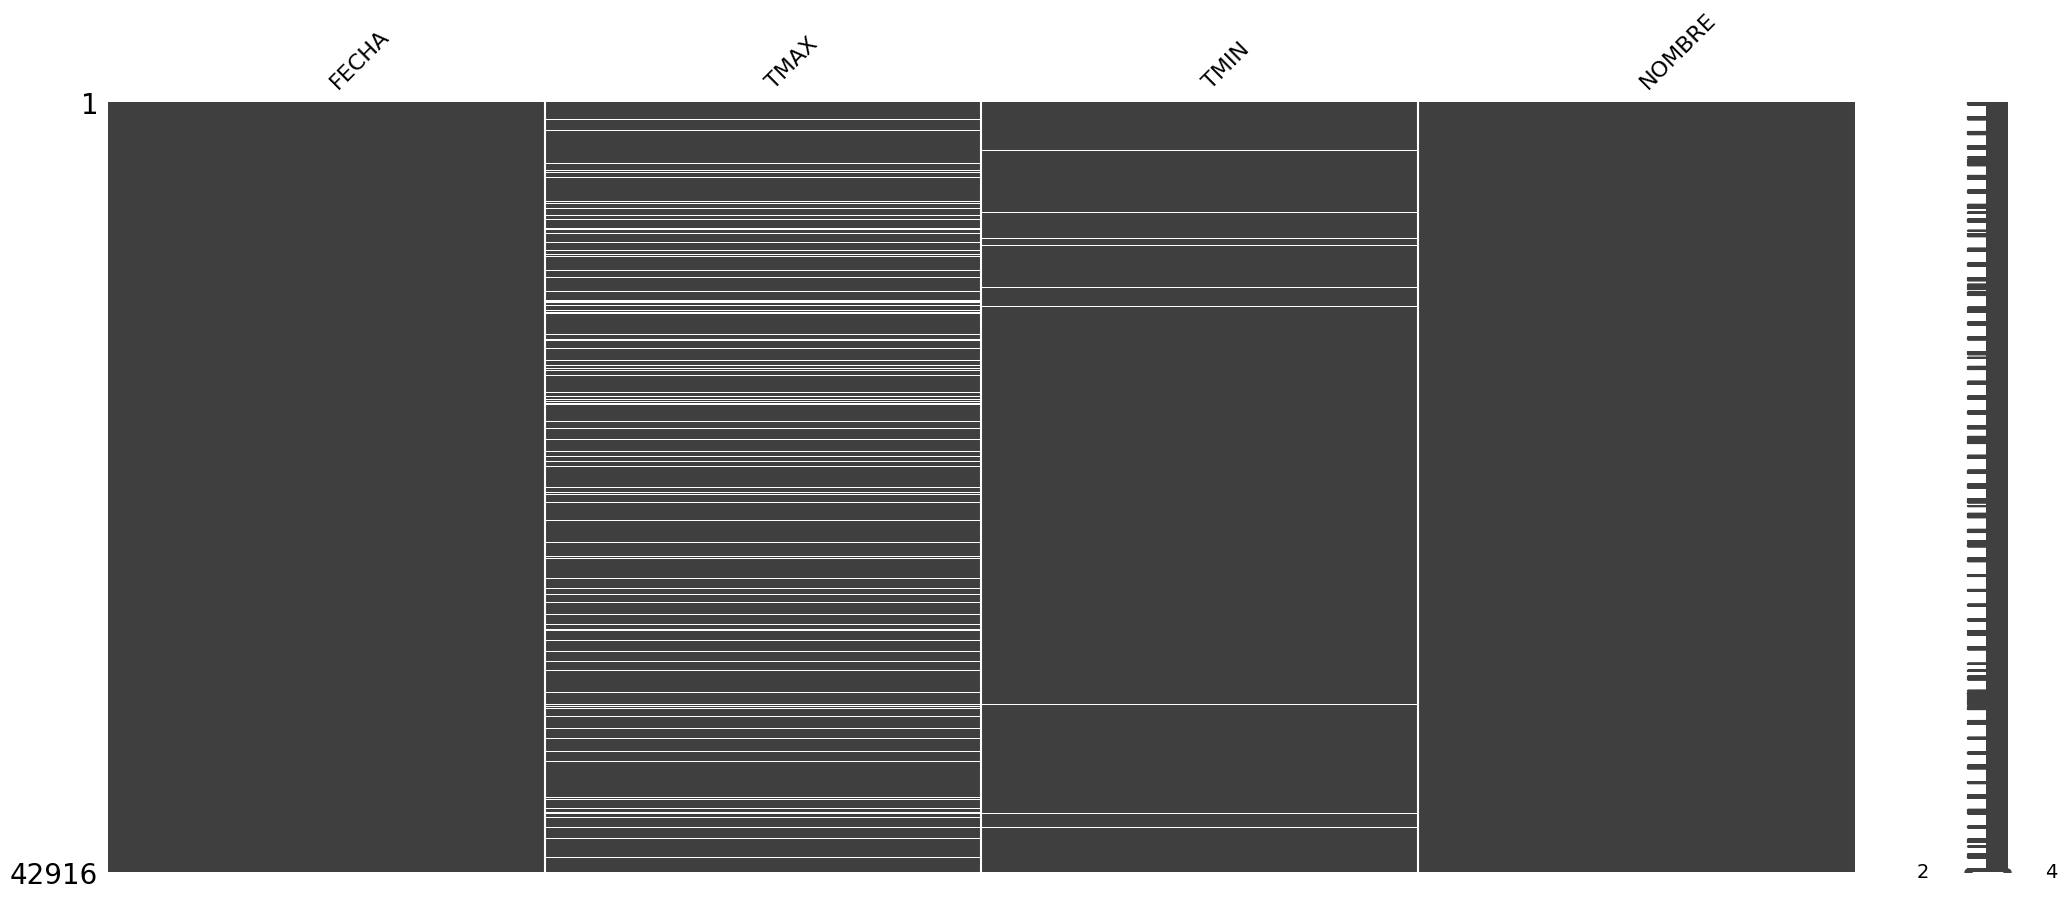

In [140]:
print('Visualizando los valores nulos')
msno.matrix(df_ly_raw);

In [141]:
print("Estaciones únicas:")
print(df_ly_raw['NOMBRE'].nunique())

Estaciones únicas:
119


A partir de la inspección inicial del dataset `df_ly_raw`, se observa lo siguiente:

- El dataset contiene una gran cantidad de filas (una por estación por día) y múltiples columnas, incluyendo fecha, temperaturas mínimas y máximas y nombre de la estación.
- Los nombres de columnas están en mayúsculas y el separador es por ancho fijo, ya que el archivo fue cargado con `read_fwf`.
- La columna `NOMBRE` representa la estación meteorológica, y hay múltiples estaciones distintas distribuidas en el país, con un total de 119.
- No hay una columna específica de provincia o ubicación geográfica, lo cual podría requerir un enriquecimiento posterior si se desea analizar por región.
- Algunas columnas tienen valores faltantes, especialmente en `TMAX` y `TMIN`, que se analizarán en profundidad en la etapa de limpieza.
- Las fechas están en formato de texto en esta etapa, y se convertirán en tipo fecha (`datetime`) más adelante.

Esta exploración inicial permite comprender la estructura general del dataset, detectar posibles inconsistencias, y planificar las transformaciones necesarias para el análisis.

---

## 2.2 Aplicación de técnicas de visualización

Se aplican herramientas gráficas como histogramas, boxplots, líneas de tiempo y otros para explorar el comportamiento de las variables principales y detectar patrones, estacionalidades o valores atípicos.

---

### Dataset: registro_temperatura365d_smn

In [142]:
df_ly = df_ly_raw.copy() # Copia del dataframe original

# Quitar filas que no tengan una fecha válida (por ejemplo, si tienen guiones)
df_ly = df_ly[df_ly['FECHA'].str.fullmatch(r"\d{8}")] # Filtrar fechas con formato de 8 dígitos (día-mes-año) 

df_ly['FECHA'] = pd.to_datetime(df_ly['FECHA'], format = '%d%m%Y') # Convertir a fecha con formato día-mes-año
df_ly['TMAX'] = pd.to_numeric(df_ly['TMAX'], errors='coerce') # Ignorar errores de conversión a numérico (por ejemplo, guiones)
df_ly['TMIN'] = pd.to_numeric(df_ly['TMIN'], errors='coerce') # Ignorar errores de conversión a numérico (por ejemplo, guiones)
df_ly['NOMBRE'] = df_ly['NOMBRE'].astype('category') # Convertir a categoría

In [143]:
### Exportación para leer en otra Notebook

# Detectar columnas categóricas
categorical_cols = [col for col, dtype in df_ly.dtypes.items() if str(dtype) == 'category']

# Guardar los tipos como strings
dtypes_str = {col: str(dtype) for col, dtype in df_ly.dtypes.items()}

# Guardar todo en un solo JSON
info = {
    "dtypes": dtypes_str,
    "categoricals": categorical_cols
}

with open("Datos/df_ly_dtypes.json", "w") as f:
    json.dump(info, f)

# exportar CSV
df_ly.to_csv('Datos/df_ly.csv', index=False)


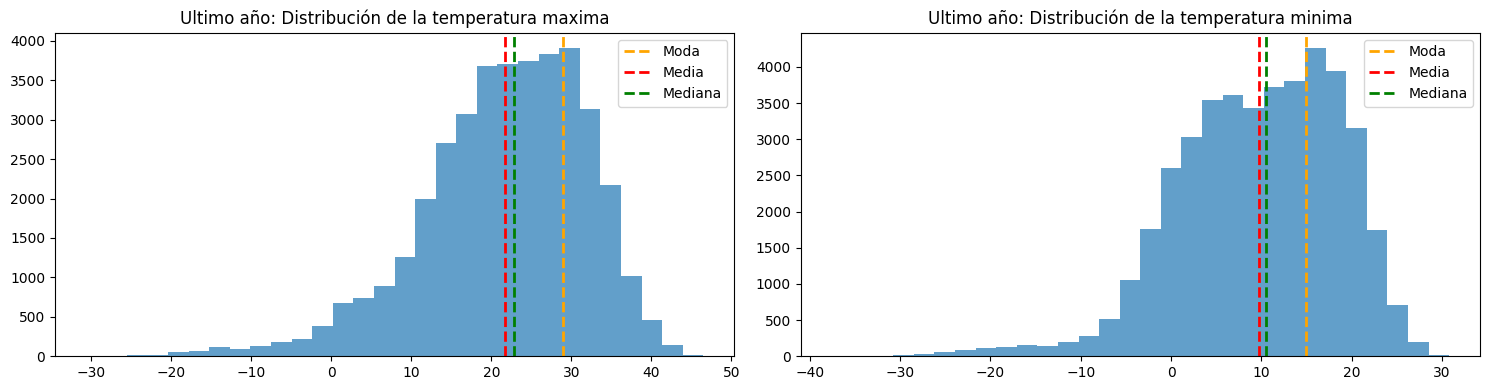

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Función para graficar
def plot_distribution(ax, data, title):
    ax.hist(data, bins=30, alpha=0.7) # dibujar histograma
    ax.axvline(data.mode()[0], color='orange', linestyle='dashed', linewidth=2, label='Moda') # dibujar la moda
    ax.axvline(data.mean(), color='red', linestyle='dashed', linewidth=2, label='Media') # dibujar la media
    ax.axvline(data.median(), color='green', linestyle='dashed', linewidth=2, label='Mediana') # dibujar la mediana
    ax.set_title(title)
    ax.legend()

plot_distribution(axes[0], df_ly['TMAX'], 'Ultimo año: Distribución de la temperatura maxima')
plot_distribution(axes[1], df_ly['TMIN'], 'Ultimo año: Distribución de la temperatura minima')

plt.tight_layout()
plt.show()

Se observan las distribuciones de temperaturas máximas y mínimas durante el último año. Las líneas verticales indican la moda (naranja), media (roja) y mediana (verde), lo que permite detectar asimetrías y valores típicos. La distribución es esperablemente amplia, dada la diversidad climática del país.

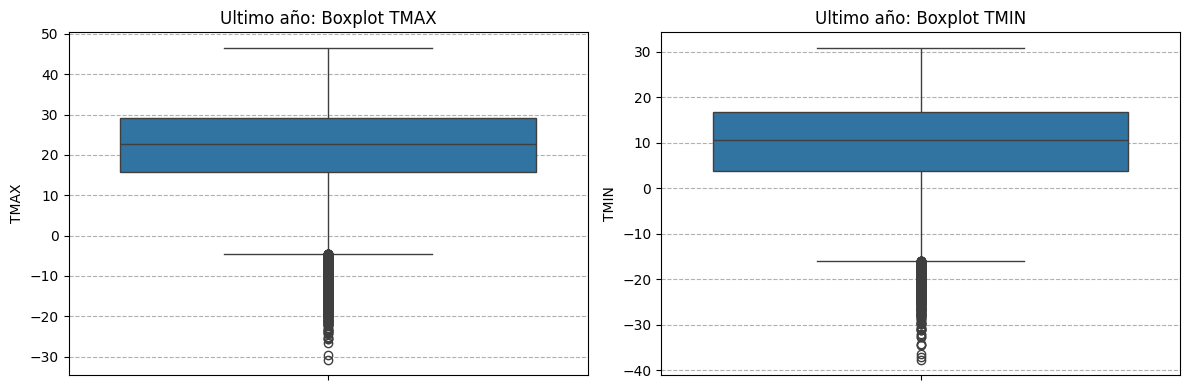

In [145]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

sns.boxplot(data=df_ly, y='TMAX', ax=ax[0])
sns.boxplot(data=df_ly, y='TMIN', ax=ax[1])

ax[0].grid(axis='y', ls='--')
ax[1].grid(axis='y', ls='--')
ax[0].set_title('Ultimo año: Boxplot TMAX')
ax[1].set_title('Ultimo año: Boxplot TMIN')

plt.tight_layout()
plt.show()

Los boxplots muestran la dispersión y los outliers en las temperaturas extremas. La presencia de valores atípicos es esperable debido a la inclusión de estaciones ubicadas en zonas con climas extremos (como la Base Marambio en la Antártida). No se eliminarán ya que representan fenómenos reales.

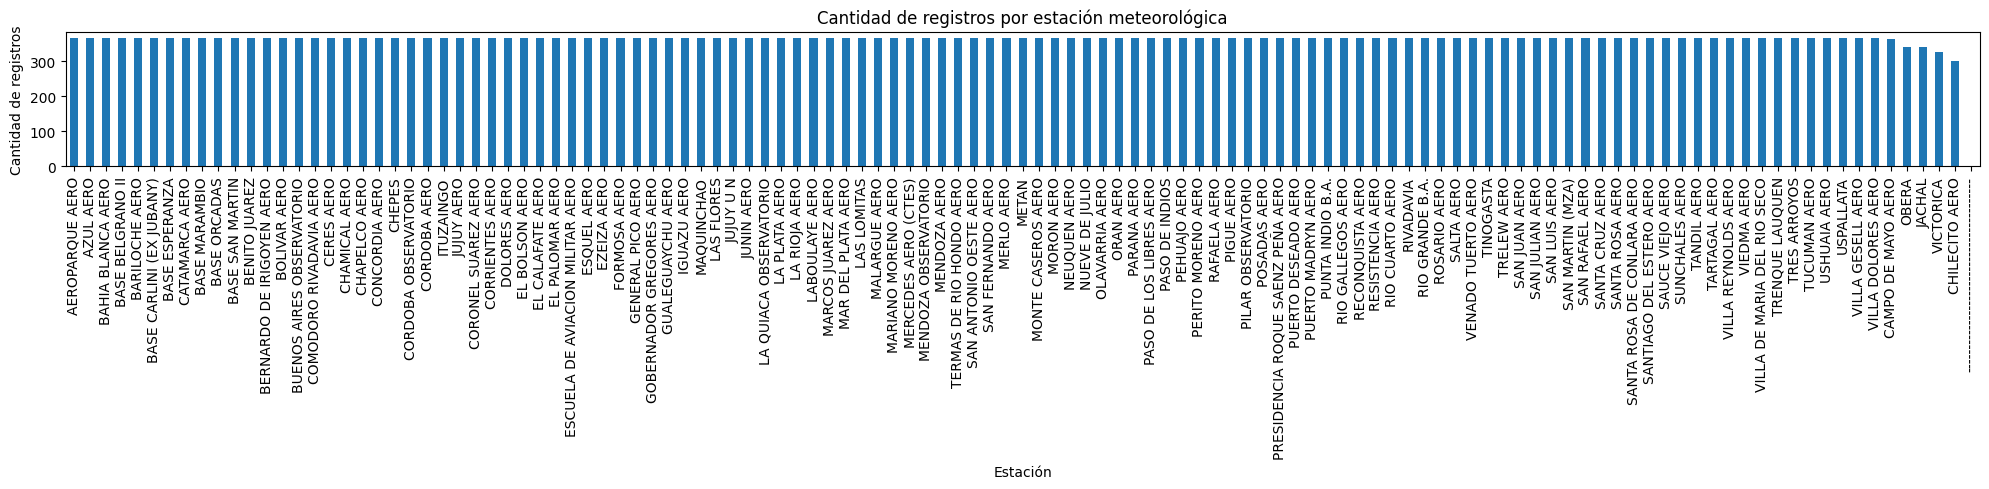

In [146]:
conteo = df_ly_raw['NOMBRE'].value_counts()

plt.figure(figsize=(20,5))
conteo.plot(kind='bar')
plt.title('Cantidad de registros por estación meteorológica')
plt.xlabel('Estación')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Aquí se muestra cuántos registros tiene cada estación meteorológica en el dataset. Algunas estaciones tienen menos de 365 registros, indicando posibles faltantes de datos o cortes en la recolección.

C:\Users\Juan\AppData\Local\Temp\ipykernel_16632\3668180416.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  incompletas = df_ly.groupby('NOMBRE').size()


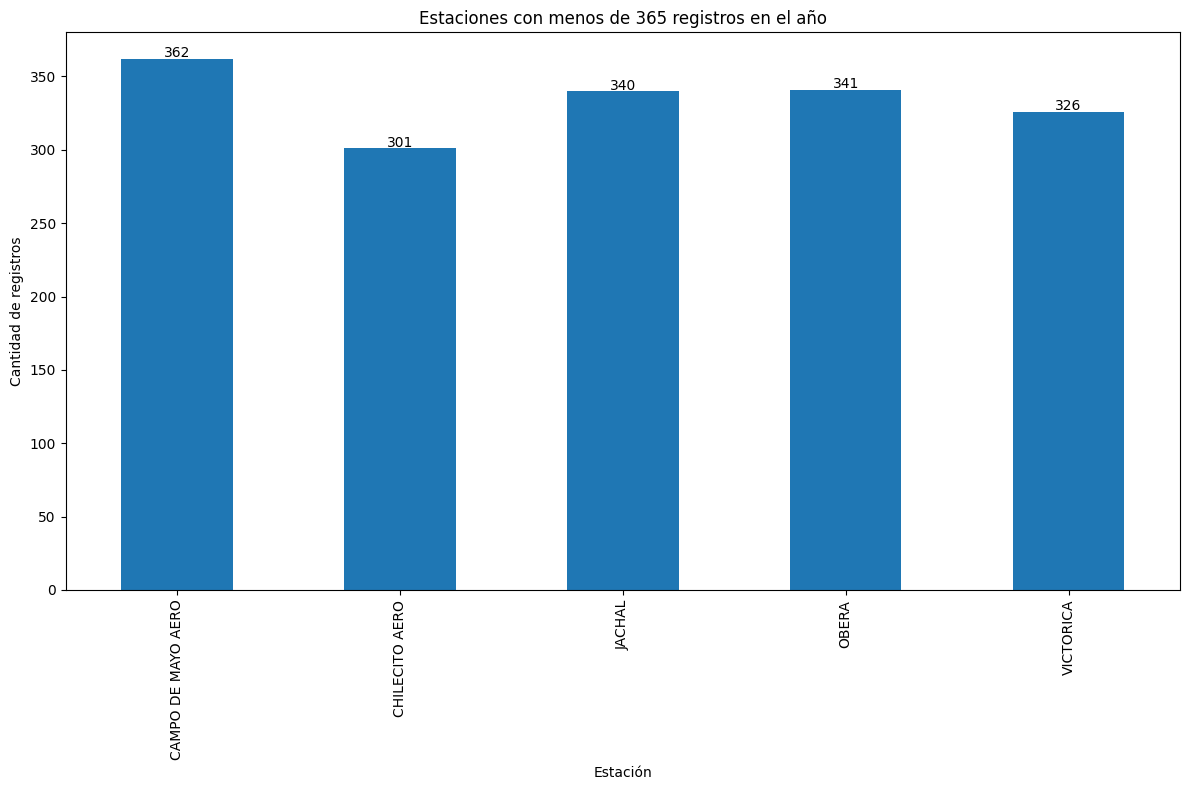

In [147]:
incompletas = df_ly.groupby('NOMBRE').size()
incompletas = incompletas[incompletas < 365]

plt.figure(figsize=(12,8))
ax = incompletas.plot(kind='bar')
plt.title('Estaciones con menos de 365 registros en el año')
plt.xlabel('Estación')
plt.ylabel('Cantidad de registros')
plt.xticks(rotation=90)

# Agregar valor encima de cada barra
for i, valor in enumerate(incompletas):
    plt.text(x=i, y=valor + 1, s=str(valor), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Este gráfico enfoca exclusivamente en las estaciones que tienen datos incompletos (menos de 365 días registrados). Las barras más bajas indican estaciones con mayor cantidad de días faltantes. Esto permite detectar posibles problemas de cobertura o interrupciones en la recolección de datos.

## 2.3 Limpieza del dataset

Aquí se aplican técnicas para tratar valores nulos, inconsistencias, tipos incorrectos o datos duplicados. Se definen reglas de limpieza y se transforman columnas para facilitar el análisis posterior.

---

### Dataset: registro_temperatura365d_smn

En esta etapa se completan las tareas de limpieza del dataset `df_ly`, que fue creado previamente como copia del original (`df_ly_raw`).

- Se eliminaron filas con fechas inválidas, conservando únicamente aquellas con formato numérico de 8 dígitos (DDMMAAAA).
- Se convirtieron las columnas `TMAX` y `TMIN` a tipo numérico, generando valores `NaN` en aquellas celdas que contenían guiones u otros valores no interpretables como números.
- La columna `FECHA` se transformó a tipo `datetime` para facilitar operaciones temporales.

In [148]:
# Leer el JSON
with open("Datos/df_final_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Detectar columnas especiales
parse_dates = [col for col, dtype in dtypes_str.items() if "datetime" in dtype]
timedeltas = [col for col, dtype in dtypes_str.items() if "timedelta" in dtype]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()
                 if col not in parse_dates + timedeltas + categorical_cols}


# leer CSV
df_ly = pd.read_csv("Datos/df_final.csv", parse_dates=parse_dates, dtype=normal_dtypes)


# Restaurar timedelta
for col in timedeltas:
    df_ly[col] = pd.to_timedelta(df_ly[col])

# Restaurar categoricals
for col in categorical_cols:
    df_ly[col] = df_ly[col].astype("category")

## 2.4 Transformación de variables y selección de features

Se transforman variables según sea necesario (por ejemplo, crear una temperatura media entre TMAX y TMIN, extraer mes o estación del año desde la fecha, etc.). También se seleccionan las variables más relevantes para el análisis.

---

### Dataset: registro_temperatura365d_smn

En esta sección se crean nuevas variables derivadas del dataset original con el objetivo de facilitar el análisis y la construcción de posibles modelos. Estas transformaciones permiten simplificar el comportamiento de ciertas variables, capturar tendencias temporales y reducir la complejidad del dataset sin perder información relevante.


In [149]:
# Cargar diccionario de regiones actualizado
region_map = pd.read_csv("Datos/estaciones_con_regiones.csv")

# Crear la columna REGION
region_dict = dict(zip(region_map["NOMBRE"], region_map["REGION"]))
df_ly["REGION"] = df_ly["NOMBRE"].map(region_dict)


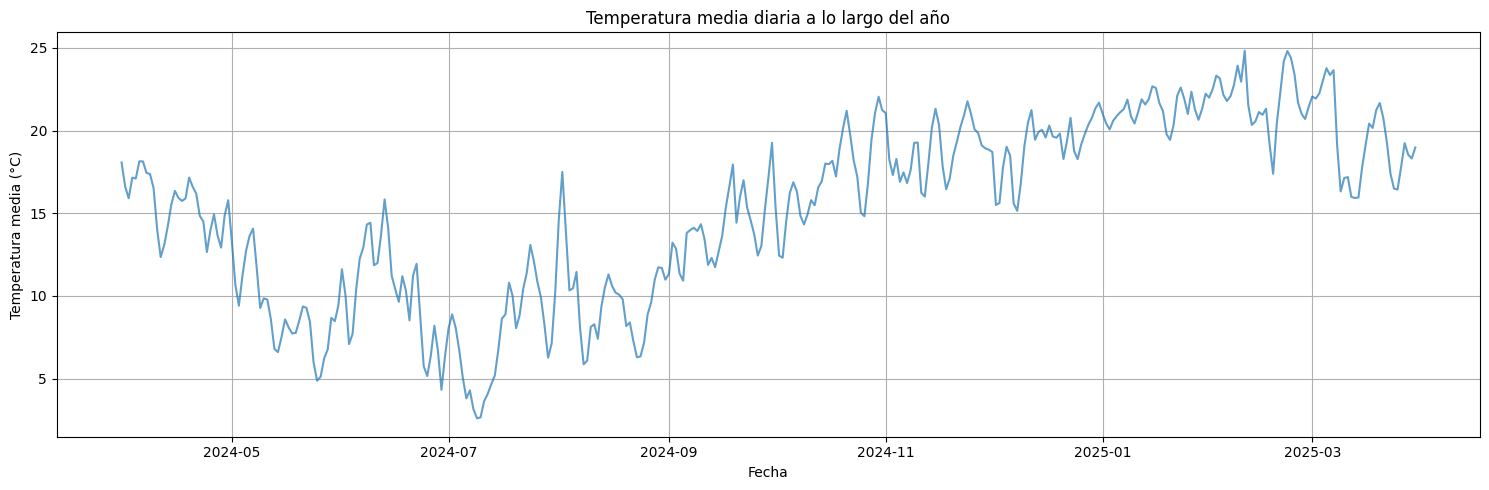

In [150]:
df_ly['TEMP_MEDIA'] = (df_ly['TMAX'] + df_ly['TMIN']) / 2

# Agrupar por fecha para tener un solo valor por día
df_grouped = df_ly.groupby('FECHA')['TEMP_MEDIA'].mean().reset_index()

plt.figure(figsize=(15,5))
plt.plot(df_grouped['FECHA'], df_grouped['TEMP_MEDIA'], alpha=0.7)
plt.title('Temperatura media diaria a lo largo del año')
plt.xlabel('Fecha')
plt.ylabel('Temperatura media (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

Este gráfico permite observar la evolución de la temperatura media diaria a lo largo del año. Se visualiza una estacionalidad clara con máximos en verano y mínimos en invierno, como es característico en el hemisferio sur.

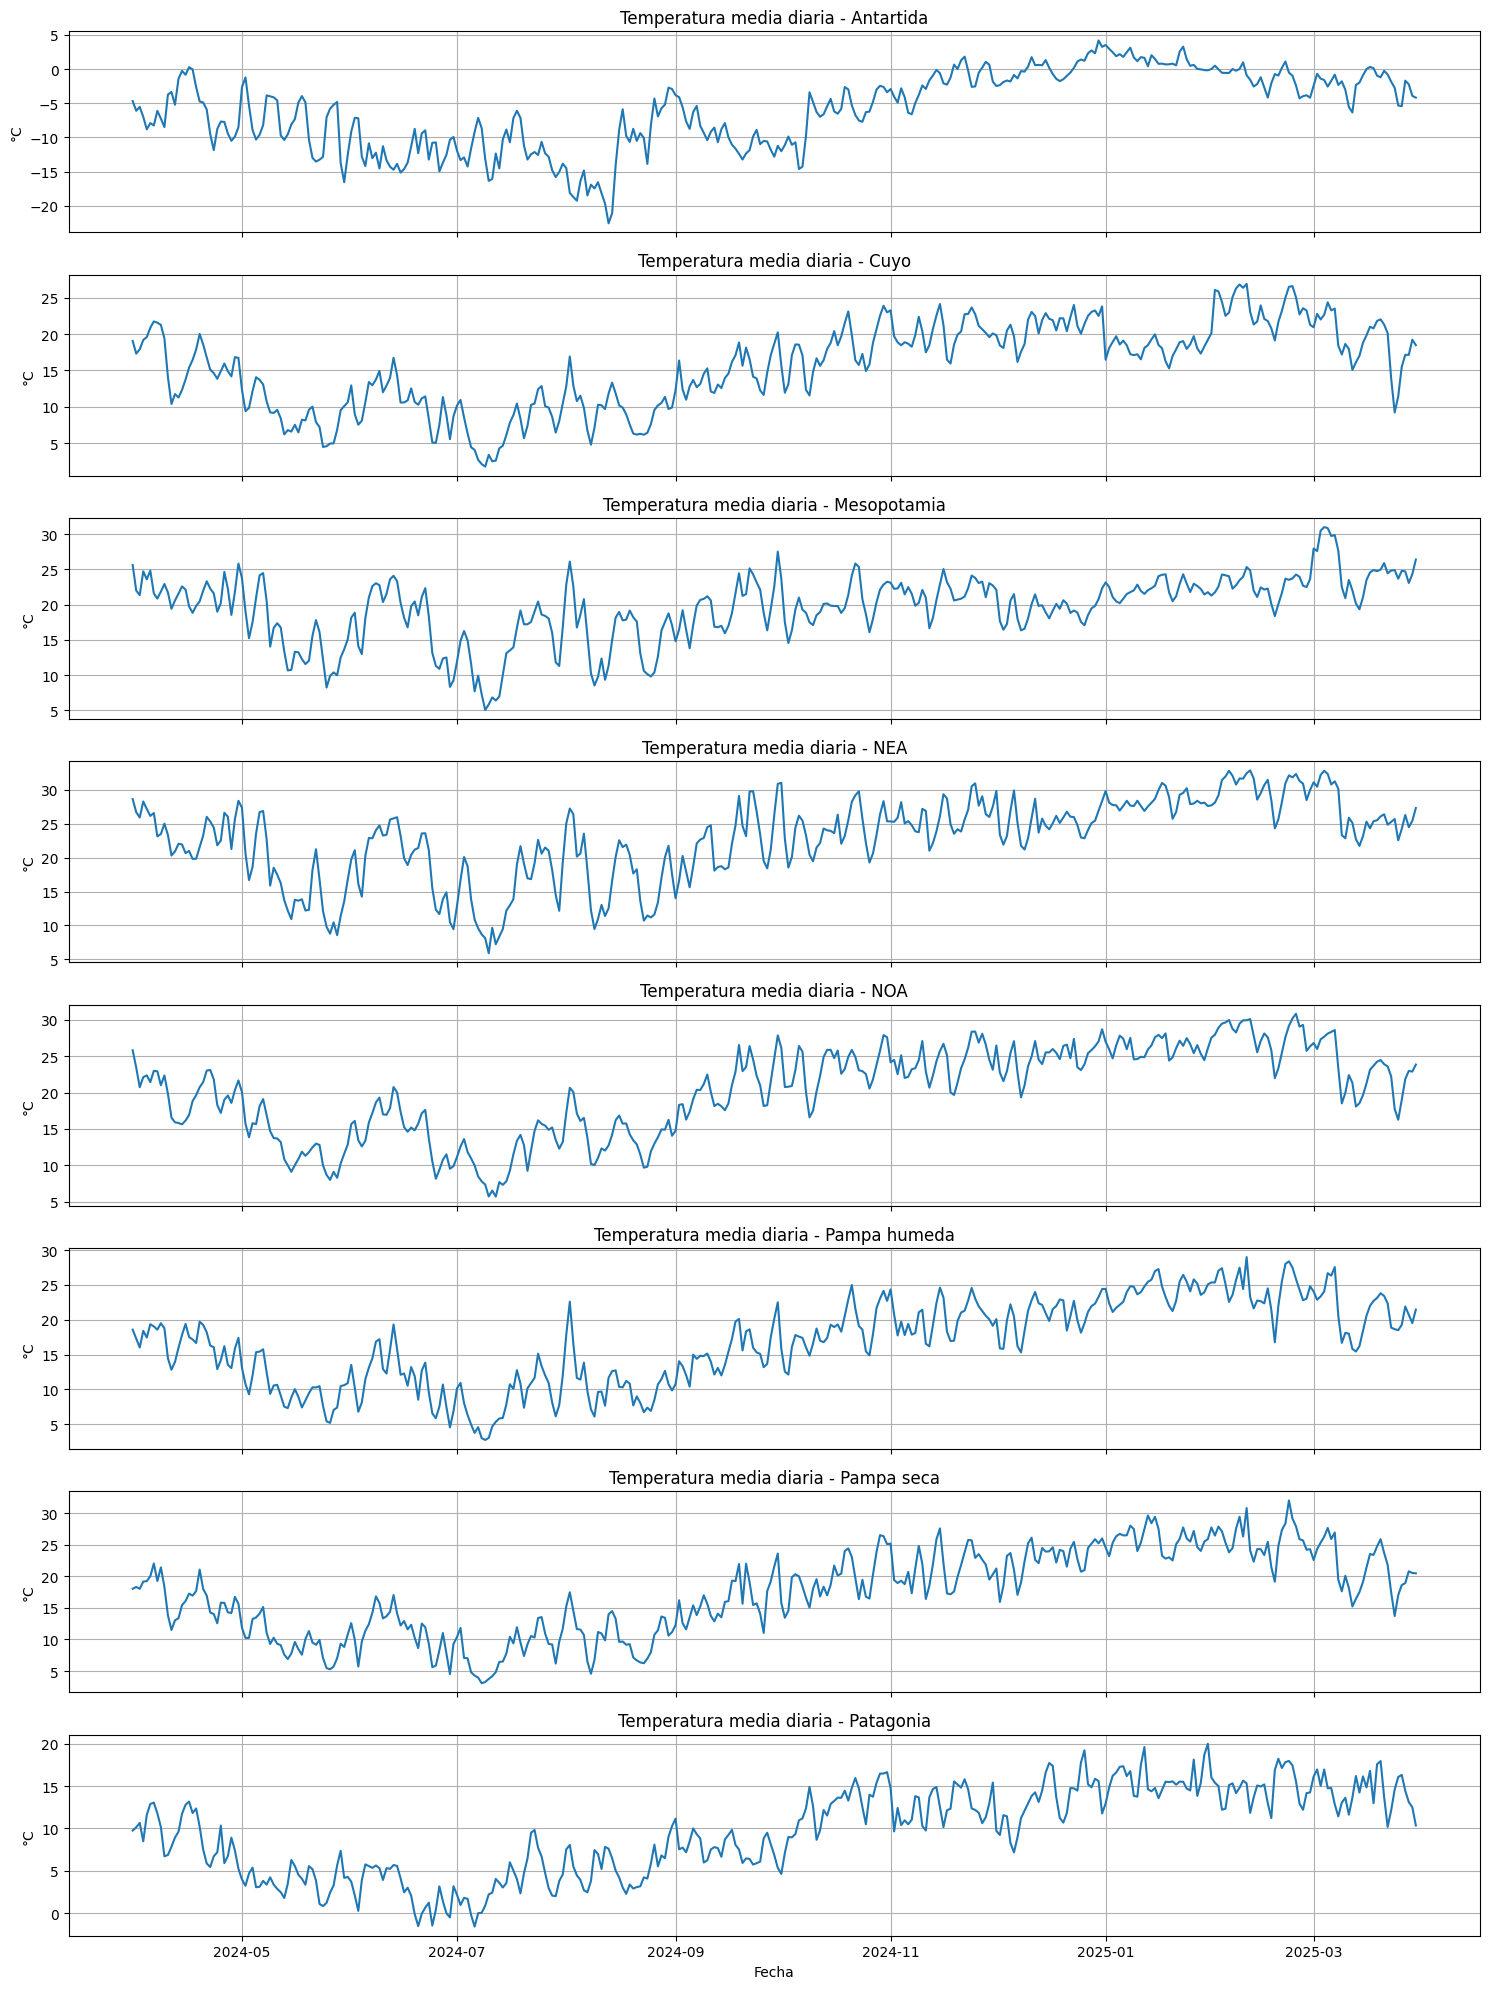

In [151]:
# Ordenamos por fecha por seguridad
df_ly = df_ly.sort_values('FECHA')

# Agrupamos por región
regiones = df_ly['REGION'].dropna().unique()
n = len(regiones)

# Creamos los subplots
fig, axes = plt.subplots(n, 1, figsize=(15, 2.5 * n), sharex=True)

for i, region in enumerate(sorted(regiones)):
    ax = axes[i]
    subset = df_ly[df_ly['REGION'] == region]
    media_diaria = subset.groupby('FECHA')['TEMP_MEDIA'].mean()
    ax.plot(media_diaria.index, media_diaria.values, label=region)
    ax.set_title(f"Temperatura media diaria - {region}")
    ax.set_ylabel("°C")
    ax.grid(True)

axes[-1].set_xlabel("Fecha")
plt.tight_layout()
plt.show()


Se calcula la temperatura media anual para cada región geográfica. Esto permite observar la variabilidad térmica en el país y detectar regiones con climas más extremos o templados.

La región más cálida del último año fue el noreste argentino y la más fría fue antartida, lo cual concuerda con las características climáticas esperadas.

C:\Users\Juan\AppData\Local\Temp\ipykernel_16632\3610457072.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='REGION', y='TEMP_MEDIA', data=df_ly, palette='Set2')


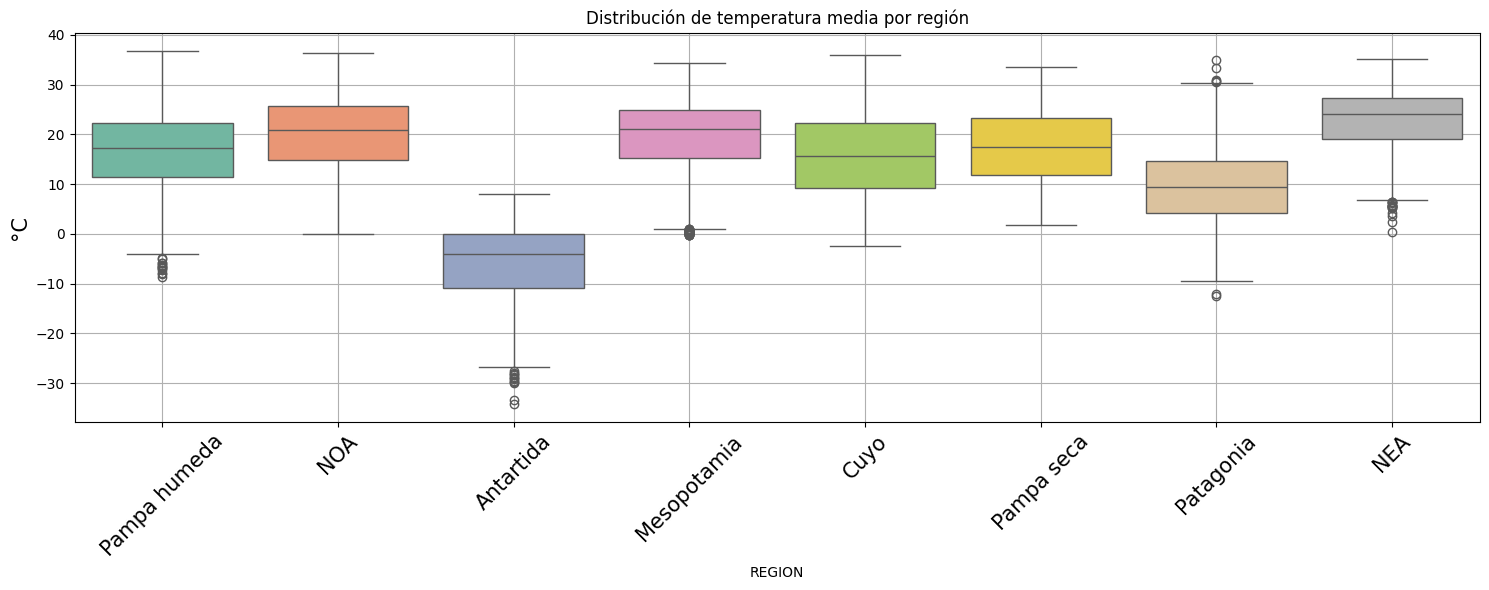

In [152]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='REGION', y='TEMP_MEDIA', data=df_ly, palette='Set2')
plt.title('Distribución de temperatura media por región')
plt.ylabel('°C', fontsize=15)
plt.xticks(rotation=45, fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()


Distribución de temperatura media por región

El boxplot permite observar la dispersión de las temperaturas medias registradas a lo largo del año para cada región. Se destacan:

- Las regiones **NEA** y **Mesopotamia**, con valores más altos y menor variabilidad.
- La **Antártida**, con temperaturas negativas y un rango más comprimido.
- **NOA** y **Cuyo** presentan una mayor amplitud térmica, lo cual refleja diferencias de altitud y continentalidad.
- Los outliers en algunas regiones corresponden a registros extremos propios de zonas particulares dentro de cada región.

Esta visualización es útil para detectar asimetrías, extremos térmicos y superposición de distribuciones.


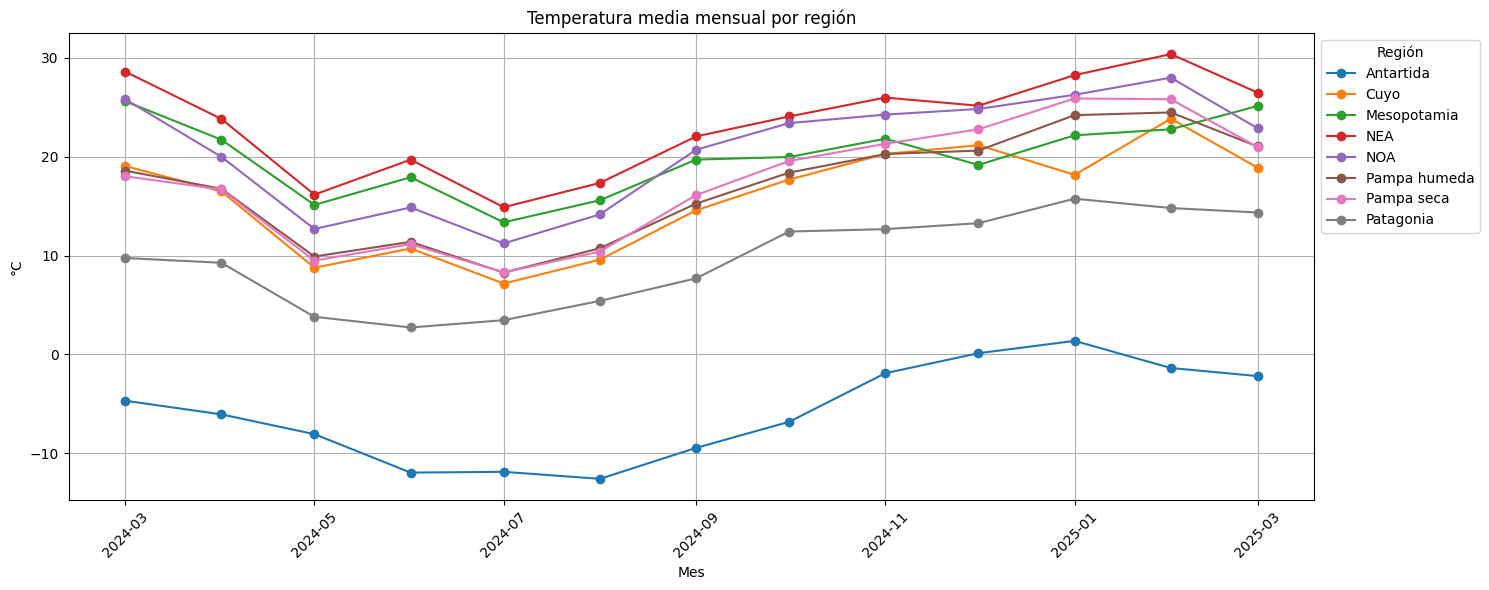

In [153]:
# Agrupar por mes (como periodo de tiempo) y región directamente
mensual = (
    df_ly
    .groupby([df_ly['FECHA'].dt.to_period('M').dt.to_timestamp(), 'REGION'])['TEMP_MEDIA']
    .mean()
    .reset_index()
    .rename(columns={'FECHA': 'AÑO_MES'})
)

# Graficar
plt.figure(figsize=(15, 6))
for region in sorted(mensual['REGION'].unique()):
    datos = mensual[mensual['REGION'] == region]
    plt.plot(datos['AÑO_MES'], datos['TEMP_MEDIA'], marker='o', label=region)

plt.title('Temperatura media mensual por región')
plt.xlabel('Mes')
plt.ylabel('°C')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Región')
plt.tight_layout()
plt.show()


Evolución mensual de temperatura media por región

Este gráfico muestra la temperatura media mensual de cada región a lo largo del año calendario. Se observa con claridad la estacionalidad en todas las regiones, con:

- Picos máximos en los meses de verano (enero-febrero).
- Mínimos en los meses de invierno (julio-agosto).
- Diferencias claras entre regiones cálidas (NEA, Mesopotamia) y frías (Patagonia, Antártida).
- La región **NEA** mantiene valores elevados incluso en invierno, debido a su baja latitud.

Este análisis permite comparar el comportamiento térmico mensual entre zonas del país, destacando patrones climáticos regionales.

Sobre el pico en junio

Durante el mes de junio se observa un leve pico en la temperatura media mensual que interrumpe la tendencia descendente habitual hacia el invierno. Esto podría explicarse por una anomalía climática localizada en algunas regiones, especialmente en las zonas templadas y cálidas, donde es posible que haya ocurrido un frente cálido prolongado, una ola de calor invernal o condiciones meteorológicas como cielos despejados y pocas lluvias que hayan contribuido a elevar las temperaturas máximas. Además, este comportamiento no se da de manera uniforme en todas las regiones: el aumento es más notorio en NEA, NOA y Mesopotamia, áreas más susceptibles a variaciones de origen tropical o subtropical, mientras que en la Antártida y la Patagonia no se presenta el mismo patrón.




## 2.5 Reducción de la dimensionalidad

### Dataset: registro_temperatura365d_smn

En este caso no se aplicaron técnicas de reducción de dimensionalidad como PCA, ya que el dataset contiene un número reducido de variables claramente interpretables y seleccionadas según su relevancia para el análisis (temperatura mínima, máxima, media, región, mes).

Dado que no se trabajará con modelos predictivos complejos ni con datasets multivariados, no se considera necesaria esta transformación.